https://tykimos.github.io/2020/10/02/BackTesting/

https://jsp-dev.tistory.com/104

- Backtrader 라이브러리의 bt.feeds.YahooFinance가 더 이상 안됨 직접 넣어줘야 함

In [181]:
from datetime import datetime
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import FinanceDataReader as fdr
import datetime
from pytz import timezone, utc

import backtrader as bt
from IPython.display import display, Image

%matplotlib inline
KST = timezone('Asia/Seoul')

# 데이터 불러오기 (by Finance Data Reader)

In [182]:
# Params
find_name = '카카오'
stt_dt = '2017-01-01'

kospi_list = fdr.StockListing('KOSPI')
k_cd = kospi_list.loc[kospi_list['Name'] == find_name,]['Symbol'].values[0]

df = fdr.DataReader(k_cd, stt_dt)

# 전략 정의

In [183]:
class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=120   # period for the slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position

In [184]:
class RSI(bt.Strategy):

    def __init__(self):
        self.rsi = bt.indicators.RSI(self.data.close)

    def next(self):
        if not self.position: # 아직 주식을 사지 않았다면
            if self.rsi < 30:
                self.order = self.buy()

        elif self.rsi > 70:
            self.order = self.sell()

## Dataset Class 정의

In [185]:
class pandasDataFeed(bt.feeds.PandasData):
    params = (
        ('fromdate', datetime.datetime(2017, 1, 1)),
        ('todate', datetime.datetime.now()), #(2020, 10, 1)),
        ('dtformat', '%Y-%m-%d'),
        ('datetime', None),
        ('high', 'High'),
        ('low', 'Low'),
        ('open', 'Open'),
        ('close', 'Close'),
        ('volume', 'Volume'),
        ('change', 'Change')
    )    
    

# 백테스팅 진행

최종금액 :  13455250.0 원
수익률 :  34.5525 %


<IPython.core.display.Javascript object>


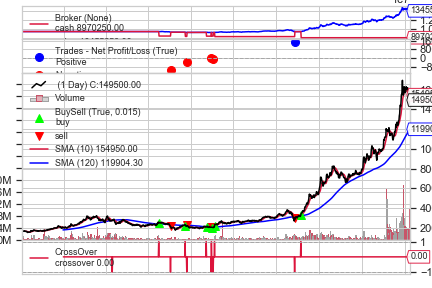

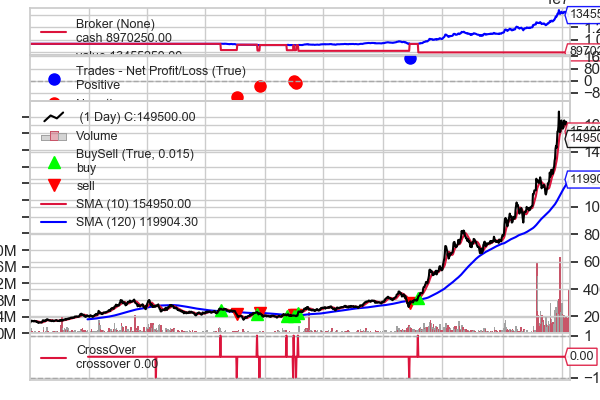

In [186]:
# 2. 세레브로(백트레이더의 엔진) 설정

# 세레브로 가져오기
cerebro = bt.Cerebro()

# 야후 금융 데이터 불러오기
#data = bt.feeds.YahooFinanceData(dataname='035420.KS', # 엔씨소프트
#                                 fromdate=datetime(2017, 1, 1), # 시작일
#                                 todate=datetime(2020, 10, 1)) # 종료일

#data = bt.feeds.PandasData(dataname=df,timeframe=1,openinterest=None)
data = pandasDataFeed(dataname=df)

# 데이터 추가하기
cerebro.adddata(data)

# 전략 추가하기
cerebro.addstrategy(SmaCross)  # Add the trading strategy
#cerebro.addstrategy(RSI)

# 브로거 설정
cerebro.broker.setcash(10000000)

# 매매 단위 설정하기
cerebro.addsizer(bt.sizers.SizerFix, stake=30) # 한번에 30주 설정

# 3. 세레브로 실행하기

# 초기 투자금 가져오기
init_cash = cerebro.broker.getvalue()

# 세레브로 실행하기
cerebro.run()

# 최종 금액 가져오기
final_cash = cerebro.broker.getvalue()

print("최종금액 : ", final_cash, "원")
print("수익률 : ", float(final_cash - init_cash)/float(init_cash) * 100., "%")

# 차트 출력하기
cerebro.plot()[0][0].savefig('plot.png', dpi=100)
display(Image(filename='plot.png'))

- 마지막까지 날짜 기준으로 수익을 확인할 수 있어야 하는 것 아닌지?